In [100]:
from manifold_learning import IMD, CCM
from manifold_learning.utils import utils
import importlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.integrate import solve_ivp
importlib.reload(IMD)
importlib.reload(utils)

<module 'manifold_learning.utils.utils' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/utils/utils.py'>

In [101]:
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [102]:
def get_truncated_lorenz_rand(tmax = 140, n_steps = 10000, sigma=10, beta=8/3, rho=28):
    initial_state = np.random.normal(size=(3))

    trunc = int(n_steps/tmax * 40) # Number of steps to get independence from initial conditions
    t_eval = np.linspace(0, tmax, trunc + n_steps)

    solution = solve_ivp(lorenz, (0, tmax), initial_state, args=(sigma, beta, rho), t_eval=t_eval).y.T[trunc:]
    return solution

In [103]:
X = np.array([np.sin(np.linspace(0,200/((i+1)*0.1337),20000)) for i in range(5)]).sum(axis=0)[:,None]
X_emb = utils.get_td_embedding_np(X,5,30,return_pred=False)[:,:,0]
#X_emb = X_emb @ np.random.normal(0,1,(30,100))
X_emb = StandardScaler().fit_transform(X_emb)

In [123]:
X = np.array([get_truncated_lorenz_rand(280,n_steps=30000)[:,0] for i in range(5)])
X = X.T @ np.random.uniform(-1,1,(5,50))
X_emb = utils.get_td_embedding_np(X,15,10,return_pred=False)
X_emb = X_emb.reshape(X_emb.shape[0],-1)
X_emb = StandardScaler().fit_transform(X_emb)

In [138]:
trainer = IMD.IMD_nD(X_emb.shape[1], embed_dim=15, n_components=5,subtract_corr=True, device="cuda")

In [154]:
trainer.fit(X_emb, sample_len=300, library_len=1000, 
            exclusion_rad=50, nbrs_num=20, tp=50, 
            epochs=1000, num_batches=32,optimizer="RMSprop", learning_rate=0.00001,tp_policy="fixed")


Epoch 1/1000, Loss: 0.4251
Epoch 2/1000, Loss: 0.4100
Epoch 3/1000, Loss: 0.4035
Epoch 4/1000, Loss: 0.4099
Epoch 5/1000, Loss: 0.4207
Epoch 6/1000, Loss: 0.4127
Epoch 7/1000, Loss: 0.4146
Epoch 8/1000, Loss: 0.4206
Epoch 9/1000, Loss: 0.4178
Epoch 10/1000, Loss: 0.4145
Epoch 11/1000, Loss: 0.4172
Epoch 12/1000, Loss: 0.4144
Epoch 13/1000, Loss: 0.4167
Epoch 14/1000, Loss: 0.4084
Epoch 15/1000, Loss: 0.4065
Epoch 16/1000, Loss: 0.3988
Epoch 17/1000, Loss: 0.3953
Epoch 18/1000, Loss: 0.3969
Epoch 19/1000, Loss: 0.3916
Epoch 20/1000, Loss: 0.3951
Epoch 21/1000, Loss: 0.3997
Epoch 22/1000, Loss: 0.3917
Epoch 23/1000, Loss: 0.3934
Epoch 24/1000, Loss: 0.3892
Epoch 25/1000, Loss: 0.3901
Epoch 26/1000, Loss: 0.3895
Epoch 27/1000, Loss: 0.3900
Epoch 28/1000, Loss: 0.3871
Epoch 29/1000, Loss: 0.3907
Epoch 30/1000, Loss: 0.3973
Epoch 31/1000, Loss: 0.3824
Epoch 32/1000, Loss: 0.3856
Epoch 33/1000, Loss: 0.3860
Epoch 34/1000, Loss: 0.3846
Epoch 35/1000, Loss: 0.3841
Epoch 36/1000, Loss: 0.3843
E

KeyboardInterrupt: 

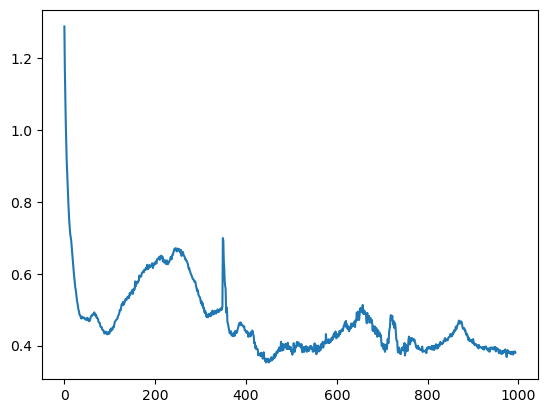

In [155]:
plt.plot(trainer.get_loss_history()[:])


In [156]:

unmixed = trainer.predict(X_emb)

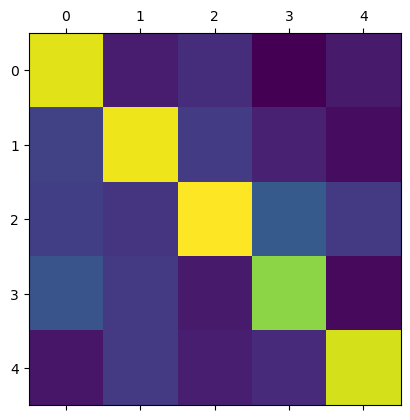

In [157]:
ccm = CCM.FastCCM(device="cpu")
plt.matshow(ccm.compute(np.transpose(unmixed,(1,0,2)), np.transpose(unmixed,(1,0,2)), 500, 150, 20, 10, 50).mean(axis=0))

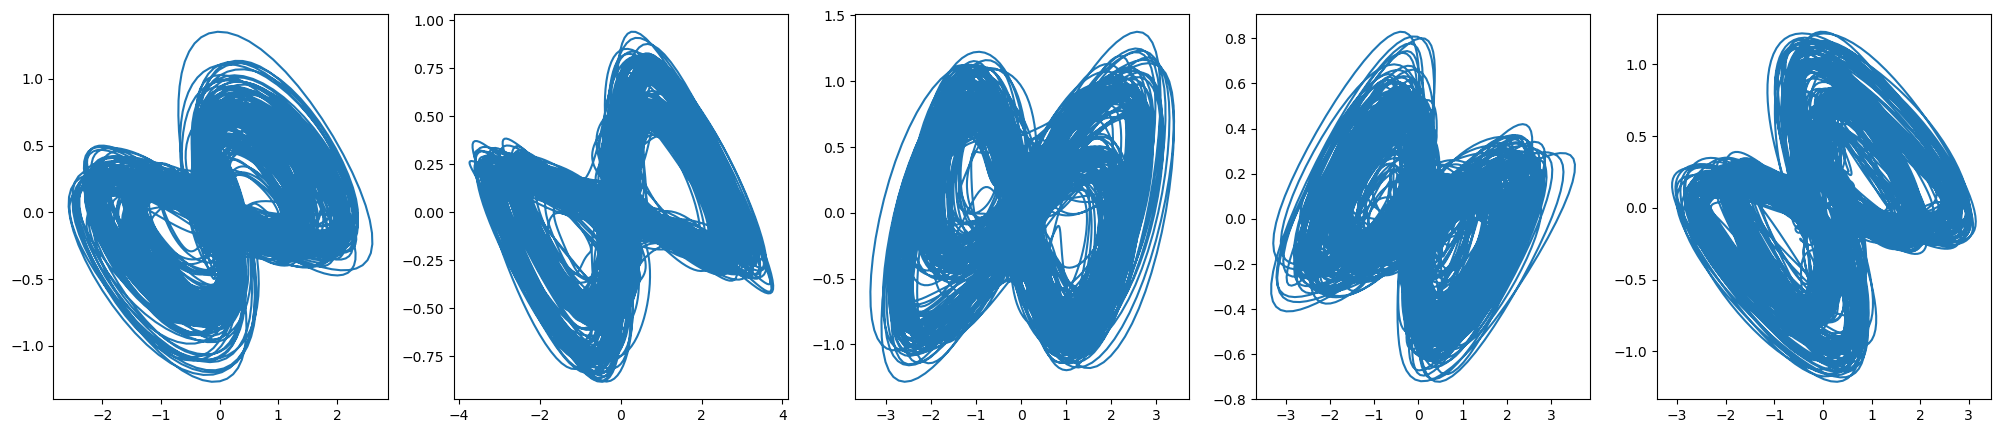

In [158]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1])

In [163]:
import plotly.express as px
x_pca = PCA(3).fit_transform(unmixed[:,0,:])
fig = px.line_3d(x=x_pca[:,0], y=x_pca[:,1],z=x_pca[:,2],height=700)

fig.show()